# test handling all collocation event lists

In [1]:
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '..')

from atl09_cloudnet.definitions.collocation import DistanceFromLocation, Duration, RadiusDuration, RawATL09, RawCloudnet
from atl09_cloudnet.definitions import vcf
from sat_val_framework import CollocationEventList

In [2]:
import os
import datetime as dt
import numpy as np
import random

In [3]:
dir_pickles = "/work/scratch-nopw2/eeasm/get_collocation_events_pickles"
assert os.path.isdir(dir_pickles)

In [4]:
sites = {
    "ny-alesund": dict(lat=78.923, lon=11.922), 
    "hyytiala": dict(lat=61.844, lon=24.287), 
    "juelich": dict(lat=50.908, lon=6.413), 
    "munich": dict(lat=48.148, lon=11.573),
}

In [5]:
SITE = "ny-alesund"
#SITE = "munich"
LATITUDE = sites[SITE]["lat"]
LONGITUDE = sites[SITE]["lon"]
SITE, LATITUDE, LONGITUDE

('ny-alesund', 78.923, 11.922)

In [6]:
fname_full_list = f"collocation_events_{SITE}.pkl"
fname_full_list

'collocation_events_ny-alesund.pkl'

In [98]:
R_km = 75#150
duration = dt.timedelta(hours=3)#72)
JOINT_PARAMS = RadiusDuration({
    RawATL09: DistanceFromLocation(
        distance_km=R_km, 
        latitude = LATITUDE,
        longitude = LONGITUDE,
    ),
    RawCloudnet: Duration(duration=duration)
})
JOINT_PARAMS

{<class 'atl09_cloudnet.definitions.raw_atl09.RawATL09'>: DistanceFromLocation(distance_km=75, latitude=78.923, longitude=11.922, MINIMUM_REQUIRED_PROFILES=50), <class 'atl09_cloudnet.definitions.raw_cloudnet.RawCloudnet'>: Duration(duration=datetime.timedelta(seconds=10800))}

In [8]:
all_collocation_events = CollocationEventList.from_file(
    os.path.join(dir_pickles, fname_full_list)
)
len(all_collocation_events)

1105

# Random event plotting

In [9]:
import matplotlib.pyplot as plt
import cmcrameri as cm
from matplotlib.patches import Circle
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from textwrap import wrap

/home/users/eeasm/mambaforge-pypy3/envs/overpass_analysis_again/lib/python3.13/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [10]:
def spatial_extent_plot(ax, raw_atl09):
    ax.coastlines("10m")
    ax.add_feature(cfeature.LAND)
    for p, pdisp in zip(raw_atl09.data.profile, (1,2,3,)):
        d = raw_atl09.data.sel(profile=p)
        ax.plot(d["longitude"], d["latitude"], transform=ccrs.PlateCarree(), label=f"{pdisp}", lw=1, c="green")
    
    ax.scatter(
        JOINT_PARAMS[RawATL09].longitude, JOINT_PARAMS[RawATL09].latitude, transform=ccrs.PlateCarree(), marker = "*", fc="red", s=500, ec="k", lw=1.5, zorder=10
    )
    
    
    limit_km = 210
    limits = [ limit_km * 1000 * p for p in (-1, 1)]
    ax.set_xlim(limits)
    ax.set_ylim(limits)
    
    tick_km = [-200, -150, -100, -50, 0, 50, 100, 150, 200]
    #tick_km = [-150, -100, -50, 0, 50, 100, 150]
    tick_m = [1000*v for v in tick_km]
    ax.set_xticks(tick_m)
    ax.set_xticklabels(tick_km)
    ax.set_xlabel("Easting (km)")
    ax.set_yticks(tick_m)
    ax.set_yticklabels(tick_km)
    ax.set_ylabel("Northing (km)")
    
    ax.add_patch(
        Circle(
            xy = (0,0),
            radius = JOINT_PARAMS[RawATL09].distance_km*1000,
            lw=2, ls="--", ec="k", 
            fc="none", #alpha=0
        )
    )
    
    #ax.add_patch(
    #    Circle(
    #        xy = (0,0),
    #        radius = 150*1000,
    #        lw=1, ls="--", ec="k", 
    #        fc="none", #alpha=0
    #    )
    #)

In [11]:
def atl09_feature_mask_criteria_plots(ax_featuremask, ax_criteria, raw_atl09):
    p=0
    pdata = (
        raw_atl09.data
            .isel(profile=p)
            #.sel(height=slice(0,10_000))
            .feature_mask
            .fillna(0)
    )
    pdata.plot(
        x="time", y="height",
        ax=ax_featuremask,
        add_colorbar=False
    )
    ax_featuremask.set_ylim([0, 12_000])
    ax_featuremask.set_xlim([pdata.time.min(), pdata.time.max()])
    
    d2s = JOINT_PARAMS[RawATL09].get_distance_to_location(raw_atl09)
    d2s.unstack().isel(profile=p).rename(f"Distance to {SITE} (km)").plot(
        x="time",
        ax=ax_criteria
    )
    ax_criteria.set_ylim([0,None])

In [12]:
def cloudnet_feature_mask_criteria_plots(ax_featuremask, ax_criteria, raw_cloudnet, t0):
    (
        raw_cloudnet.data.cloudmask
            .sel(height=slice(0,12_000))
    ).plot(
        x="time", y="height",
        ax=ax_featuremask,
        add_colorbar=False
    )

    abs_t_t0 = np.abs(
        (raw_cloudnet.data.time - np.datetime64(t0)) * 1e-9
    ).rename(r"$|t - t_{0}|$ (s)")
    abs_t_t0.plot(
        x="time",
        ax=ax_criteria
    )
    ax_criteria.set_ylim([0, None])

# CollocatedHomogenisedData generators

In [13]:
import xarray as xr
def pair_vcf_dataset_from_collocated_homogenised_data(coll_H):
    vcf_atl09 = coll_H[RawATL09].data
    vcf_cloudnet = coll_H[RawCloudnet].data
    return xr.merge([
        vcf_atl09.rename("vcf_atl09"), vcf_cloudnet.rename("vcf_cloudnet")
    ]).copy(deep=True)

In [14]:
slice_of_events = slice(0,10)

In [15]:
%%time
collocated_raw_data = (
    raw_data
    for collocation_event in all_collocation_events[slice_of_events]
    if (raw_data := collocation_event.load_with_joint_parameters(JOINT_PARAMS)) is not None
    if not any(
        value is None 
        for value in (raw_data).values()
    )
)

CPU times: user 34 μs, sys: 5 μs, total: 39 μs
Wall time: 43.2 μs


In [16]:
%%time
collocated_homogenised_data = (
    collocated_h := raw_data_pair.homogenise_to(vcf.VCF_240m)
    for raw_data_pair in collocated_raw_data
)

CPU times: user 5 μs, sys: 1 μs, total: 6 μs
Wall time: 9.3 μs


In [17]:
%%time
events_considered = 0
paired_vcfs = (
    (pair_vcf_dataset_from_collocated_homogenised_data(coll_H), events_considered := events_considered + 1)[0]
    for coll_H in collocated_homogenised_data
)

CPU times: user 5 μs, sys: 0 ns, total: 5 μs
Wall time: 8.58 μs


In [18]:
%%time
multiple_vcf_pairs = xr.concat(
    paired_vcfs,
    dim="collocation_event"
)
multiple_vcf_pairs

/home/users/eeasm/_scripts/sat-val-framework/example/local_tests/../atl09_cloudnet/definitions/raw_atl09.py:140: UserWarning: rename 'ds_va_bin_h' to 'height' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  .rename({
/home/users/eeasm/_scripts/sat-val-framework/example/local_tests/../atl09_cloudnet/definitions/raw_cloudnet.py:196: UserWarning: Discarding nonzero nanoseconds in conversion.
  min_time = Timestamp(new_data.time.min().values).to_pydatetime()
/home/users/eeasm/_scripts/sat-val-framework/example/local_tests/../atl09_cloudnet/definitions/raw_cloudnet.py:197: UserWarning: Discarding nonzero nanoseconds in conversion.
  max_time = Timestamp(new_data.time.max().values).to_pydatetime()


Known failure type: <class 'FileNotFoundError'> [Errno 2] No such file or directory: '/gws/nopw/j04/icecaps/eeasm/paper1/sites/ny-alesund/cloudnet/20190610_ny-alesund_categorize.nc'
Known failure type: <class 'FileNotFoundError'> [Errno 2] No such file or directory: '/gws/nopw/j04/icecaps/eeasm/paper1/sites/ny-alesund/cloudnet/20190611_ny-alesund_categorize.nc'


/home/users/eeasm/_scripts/sat-val-framework/example/local_tests/../atl09_cloudnet/definitions/raw_atl09.py:140: UserWarning: rename 'ds_va_bin_h' to 'height' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  .rename({
/home/users/eeasm/_scripts/sat-val-framework/example/local_tests/../atl09_cloudnet/definitions/raw_cloudnet.py:196: UserWarning: Discarding nonzero nanoseconds in conversion.
  min_time = Timestamp(new_data.time.min().values).to_pydatetime()
/home/users/eeasm/_scripts/sat-val-framework/example/local_tests/../atl09_cloudnet/definitions/raw_cloudnet.py:197: UserWarning: Discarding nonzero nanoseconds in conversion.
  max_time = Timestamp(new_data.time.max().values).to_pydatetime()


Known failure type: <class 'FileNotFoundError'> [Errno 2] No such file or directory: '/gws/nopw/j04/icecaps/eeasm/paper1/sites/ny-alesund/cloudnet/20190611_ny-alesund_categorize.nc'


/home/users/eeasm/_scripts/sat-val-framework/example/local_tests/../atl09_cloudnet/definitions/raw_atl09.py:140: UserWarning: rename 'ds_va_bin_h' to 'height' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  .rename({
/home/users/eeasm/_scripts/sat-val-framework/example/local_tests/../atl09_cloudnet/definitions/raw_cloudnet.py:196: UserWarning: Discarding nonzero nanoseconds in conversion.
  min_time = Timestamp(new_data.time.min().values).to_pydatetime()
/home/users/eeasm/_scripts/sat-val-framework/example/local_tests/../atl09_cloudnet/definitions/raw_cloudnet.py:197: UserWarning: Discarding nonzero nanoseconds in conversion.
  max_time = Timestamp(new_data.time.max().values).to_pydatetime()
/home/users/eeasm/_scripts/sat-val-framework/example/local_tests/../atl09_cloudnet/definitions/raw_atl09.py:140: UserWarning: rename 'ds_va_bin_h' to 'height' does not create an index anymore. Try using swap_dims instead

Whelp, this is boring


/home/users/eeasm/_scripts/sat-val-framework/example/local_tests/../atl09_cloudnet/definitions/raw_cloudnet.py:196: UserWarning: Discarding nonzero nanoseconds in conversion.
  min_time = Timestamp(new_data.time.min().values).to_pydatetime()
/home/users/eeasm/_scripts/sat-val-framework/example/local_tests/../atl09_cloudnet/definitions/raw_cloudnet.py:197: UserWarning: Discarding nonzero nanoseconds in conversion.
  max_time = Timestamp(new_data.time.max().values).to_pydatetime()
/home/users/eeasm/_scripts/sat-val-framework/example/local_tests/../atl09_cloudnet/definitions/raw_atl09.py:140: UserWarning: rename 'ds_va_bin_h' to 'height' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  .rename({
/home/users/eeasm/_scripts/sat-val-framework/example/local_tests/../atl09_cloudnet/definitions/raw_cloudnet.py:196: UserWarning: Discarding nonzero nanoseconds in conversion.
  min_time = Timestamp(new_data.time.min().va

CPU times: user 5min 33s, sys: 8.37 s, total: 5min 42s
Wall time: 5min 58s


<xarray.Dataset> Size: 8kB
Dimensions:       (collocation_event: 10, height: 50)
Coordinates:
  * height        (height) int64 400B 0 240 480 720 ... 11040 11280 11520 11760
Dimensions without coordinates: collocation_event
Data variables:
    vcf_atl09     (collocation_event, height) float64 4kB 0.0003151 ... 0.0
    vcf_cloudnet  (collocation_event, height) float64 4kB 0.0 0.6947 ... 0.0 0.0

In [19]:
events_considered

10

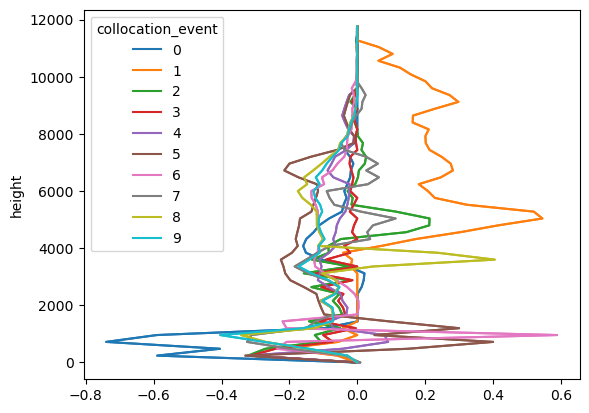

In [22]:
(multiple_vcf_pairs.vcf_atl09 - multiple_vcf_pairs.vcf_cloudnet).plot(y="height", hue="collocation_event")
plt.show()

# Loading with generators and logging print statements
Using some truly vile code, we can do print statements and stateful-value editing within generator expressions

In [104]:
from typing import Callable, Any
def make_safe(func: Callable[[Any],Any]) -> Callable[[Any],Any|None]:
    def safe_func(*args, **kwargs):
        try:
            value = func(*args, **kwargs)
            success = True
        except Exception as e:
            value = f"""make_safe({func.__name__}) thrown exception
{type(e)}, {e}"""
            success = False
        return (value, success)
    return safe_func

filter_none = lambda generator: (v for v in generator if v is not None)

In [108]:
%%time

slice_of_events = slice(100,110)

events_to_load = (
    (event, print("\n",f"LOADING",event))[0]
    for event in all_collocation_events[slice_of_events]
)

# load an event to a CollocatedRawData instance, and catch exceptions in loading
N_fail_on_load = 0
collocated_raw_data = filter_none((
    raw_data[0]
    
    if (
        raw_data := make_safe(collocation_event.load_with_joint_parameters)(JOINT_PARAMS)
    )[1]
    
    else (
        None,
        print(raw_data[0]),
        print(f"ABORTING due to failed loading"),
        N_fail_on_load:=N_fail_on_load+1,
    )[0]
    
    for collocation_event in events_to_load
))

# filter for any of the elements of CollocatedRawData instances being None
N_fail_with_raw_data_None = 0
collocated_raw_data = filter_none((
    raw_data
    
    if not any(
        value is None 
        for value in (raw_data).values()
    )
    else (
        None,
        print(f"ABORTING: None value found in collocated raw data, { {k: (type(v) is None) for k,v in raw_data.items()}= }"),
        N_fail_with_raw_data_None:=N_fail_with_raw_data_None+1
    )[0]
    
    for raw_data in collocated_raw_data  
))

# homogenise data, and catch exceptions
N_fail_homogenisation = 0
collocated_homogenised_data = filter_none((
    collocated_h[0]
    
    if (
        collocated_h := make_safe(raw_data_pair.homogenise_to)(vcf.VCF_240m)
    )[1]
    else (
        None,
        print(collocated_h[0]),
        print(f"ABORTING: error thrown in homogenisation"),
        N_fail_homogenisation:=N_fail_homogenisation+1,
    )[0]
    
    for raw_data_pair in collocated_raw_data
))

# create vcf data arrays from succesfully homogenised data
N_success = 0
paired_vcfs = (
    (
        pair_vcf_dataset_from_collocated_homogenised_data(coll_H),
        print(f"SUCCESS: homogenised data loaded to xarray DataArray"),
        N_success:=N_success + 1
    )[0]
    
    for coll_H in collocated_homogenised_data
)

multiple_vcf_pairs = xr.concat(
    paired_vcfs,
    dim="collocation_event"
)
multiple_vcf_pairs


 LOADING {<class 'atl09_cloudnet.definitions.raw_atl09.RawATL09'>: ATL09Event(fpath1='/gws/nopw/j04/icecaps/eeasm/paper1/sites/ny-alesund/atl09/processed_ATL09_20191209180342_11280501_006_01.h5', fpath2=None), <class 'atl09_cloudnet.definitions.raw_cloudnet.RawCloudnet'>: CloudnetEvent(closest_approach_time=datetime.datetime(2019, 12, 9, 18, 24, 19, 671313), root_dir='/gws/nopw/j04/icecaps/eeasm/paper1/sites/ny-alesund/cloudnet', site='ny-alesund')}


/home/users/eeasm/_scripts/sat-val-framework/example/local_tests/../atl09_cloudnet/definitions/raw_atl09.py:140: UserWarning: rename 'ds_va_bin_h' to 'height' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  .rename({


Whelp, this is boring


/home/users/eeasm/_scripts/sat-val-framework/example/local_tests/../atl09_cloudnet/definitions/raw_cloudnet.py:196: UserWarning: Discarding nonzero nanoseconds in conversion.
  min_time = Timestamp(new_data.time.min().values).to_pydatetime()
/home/users/eeasm/_scripts/sat-val-framework/example/local_tests/../atl09_cloudnet/definitions/raw_cloudnet.py:197: UserWarning: Discarding nonzero nanoseconds in conversion.
  max_time = Timestamp(new_data.time.max().values).to_pydatetime()
/home/users/eeasm/mambaforge-pypy3/envs/overpass_analysis_again/lib/python3.13/site-packages/numpy/_core/_methods.py:137: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


make_safe(homogenise_to) thrown exception
<class 'AssertionError'>, All vertical cloud fractions must fall within bounds [0,1]
ABORTING: error thrown in homogenisation

 LOADING {<class 'atl09_cloudnet.definitions.raw_atl09.RawATL09'>: ATL09Event(fpath1='/gws/nopw/j04/icecaps/eeasm/paper1/sites/ny-alesund/atl09/processed_ATL09_20191210063801_11360501_006_01.h5', fpath2=None), <class 'atl09_cloudnet.definitions.raw_cloudnet.RawCloudnet'>: CloudnetEvent(closest_approach_time=datetime.datetime(2019, 12, 10, 7, 4, 26, 872421), root_dir='/gws/nopw/j04/icecaps/eeasm/paper1/sites/ny-alesund/cloudnet', site='ny-alesund')}


/home/users/eeasm/_scripts/sat-val-framework/example/local_tests/../atl09_cloudnet/definitions/raw_atl09.py:140: UserWarning: rename 'ds_va_bin_h' to 'height' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  .rename({
/home/users/eeasm/_scripts/sat-val-framework/example/local_tests/../atl09_cloudnet/definitions/raw_cloudnet.py:196: UserWarning: Discarding nonzero nanoseconds in conversion.
  min_time = Timestamp(new_data.time.min().values).to_pydatetime()
/home/users/eeasm/_scripts/sat-val-framework/example/local_tests/../atl09_cloudnet/definitions/raw_cloudnet.py:197: UserWarning: Discarding nonzero nanoseconds in conversion.
  max_time = Timestamp(new_data.time.max().values).to_pydatetime()


SUCCESS: homogenised data loaded to xarray DataArray

 LOADING {<class 'atl09_cloudnet.definitions.raw_atl09.RawATL09'>: ATL09Event(fpath1='/gws/nopw/j04/icecaps/eeasm/paper1/sites/ny-alesund/atl09/processed_ATL09_20191210173803_11430501_006_01.h5', fpath2=None), <class 'atl09_cloudnet.definitions.raw_cloudnet.RawCloudnet'>: CloudnetEvent(closest_approach_time=datetime.datetime(2019, 12, 10, 17, 58, 42, 513375), root_dir='/gws/nopw/j04/icecaps/eeasm/paper1/sites/ny-alesund/cloudnet', site='ny-alesund')}


/home/users/eeasm/_scripts/sat-val-framework/example/local_tests/../atl09_cloudnet/definitions/raw_atl09.py:140: UserWarning: rename 'ds_va_bin_h' to 'height' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  .rename({
/home/users/eeasm/_scripts/sat-val-framework/example/local_tests/../atl09_cloudnet/definitions/raw_cloudnet.py:196: UserWarning: Discarding nonzero nanoseconds in conversion.
  min_time = Timestamp(new_data.time.min().values).to_pydatetime()
/home/users/eeasm/_scripts/sat-val-framework/example/local_tests/../atl09_cloudnet/definitions/raw_cloudnet.py:197: UserWarning: Discarding nonzero nanoseconds in conversion.
  max_time = Timestamp(new_data.time.max().values).to_pydatetime()


SUCCESS: homogenised data loaded to xarray DataArray

 LOADING {<class 'atl09_cloudnet.definitions.raw_atl09.RawATL09'>: ATL09Event(fpath1='/gws/nopw/j04/icecaps/eeasm/paper1/sites/ny-alesund/atl09/processed_ATL09_20191211171223_11580501_006_01.h5', fpath2=None), <class 'atl09_cloudnet.definitions.raw_cloudnet.RawCloudnet'>: CloudnetEvent(closest_approach_time=datetime.datetime(2019, 12, 11, 17, 33, 7, 29438), root_dir='/gws/nopw/j04/icecaps/eeasm/paper1/sites/ny-alesund/cloudnet', site='ny-alesund')}


/home/users/eeasm/_scripts/sat-val-framework/example/local_tests/../atl09_cloudnet/definitions/raw_atl09.py:140: UserWarning: rename 'ds_va_bin_h' to 'height' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  .rename({


Whelp, this is boring


/home/users/eeasm/_scripts/sat-val-framework/example/local_tests/../atl09_cloudnet/definitions/raw_cloudnet.py:196: UserWarning: Discarding nonzero nanoseconds in conversion.
  min_time = Timestamp(new_data.time.min().values).to_pydatetime()
/home/users/eeasm/_scripts/sat-val-framework/example/local_tests/../atl09_cloudnet/definitions/raw_cloudnet.py:197: UserWarning: Discarding nonzero nanoseconds in conversion.
  max_time = Timestamp(new_data.time.max().values).to_pydatetime()
/home/users/eeasm/mambaforge-pypy3/envs/overpass_analysis_again/lib/python3.13/site-packages/numpy/_core/_methods.py:137: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


make_safe(homogenise_to) thrown exception
<class 'AssertionError'>, All vertical cloud fractions must fall within bounds [0,1]
ABORTING: error thrown in homogenisation

 LOADING {<class 'atl09_cloudnet.definitions.raw_atl09.RawATL09'>: ATL09Event(fpath1='/gws/nopw/j04/icecaps/eeasm/paper1/sites/ny-alesund/atl09/processed_ATL09_20191218062122_12580501_006_01.h5', fpath2=None), <class 'atl09_cloudnet.definitions.raw_cloudnet.RawCloudnet'>: CloudnetEvent(closest_approach_time=datetime.datetime(2019, 12, 18, 6, 47, 47, 309195), root_dir='/gws/nopw/j04/icecaps/eeasm/paper1/sites/ny-alesund/cloudnet', site='ny-alesund')}


/home/users/eeasm/_scripts/sat-val-framework/example/local_tests/../atl09_cloudnet/definitions/raw_atl09.py:140: UserWarning: rename 'ds_va_bin_h' to 'height' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  .rename({
/home/users/eeasm/_scripts/sat-val-framework/example/local_tests/../atl09_cloudnet/definitions/raw_cloudnet.py:196: UserWarning: Discarding nonzero nanoseconds in conversion.
  min_time = Timestamp(new_data.time.min().values).to_pydatetime()
/home/users/eeasm/_scripts/sat-val-framework/example/local_tests/../atl09_cloudnet/definitions/raw_cloudnet.py:197: UserWarning: Discarding nonzero nanoseconds in conversion.
  max_time = Timestamp(new_data.time.max().values).to_pydatetime()


SUCCESS: homogenised data loaded to xarray DataArray

 LOADING {<class 'atl09_cloudnet.definitions.raw_atl09.RawATL09'>: ATL09Event(fpath1='/gws/nopw/j04/icecaps/eeasm/paper1/sites/ny-alesund/atl09/processed_ATL09_20191218172124_12650501_006_01.h5', fpath2=None), <class 'atl09_cloudnet.definitions.raw_cloudnet.RawCloudnet'>: CloudnetEvent(closest_approach_time=datetime.datetime(2019, 12, 18, 17, 42, 3, 30148), root_dir='/gws/nopw/j04/icecaps/eeasm/paper1/sites/ny-alesund/cloudnet', site='ny-alesund')}


/home/users/eeasm/_scripts/sat-val-framework/example/local_tests/../atl09_cloudnet/definitions/raw_atl09.py:140: UserWarning: rename 'ds_va_bin_h' to 'height' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  .rename({
/home/users/eeasm/_scripts/sat-val-framework/example/local_tests/../atl09_cloudnet/definitions/raw_cloudnet.py:196: UserWarning: Discarding nonzero nanoseconds in conversion.
  min_time = Timestamp(new_data.time.min().values).to_pydatetime()
/home/users/eeasm/_scripts/sat-val-framework/example/local_tests/../atl09_cloudnet/definitions/raw_cloudnet.py:197: UserWarning: Discarding nonzero nanoseconds in conversion.
  max_time = Timestamp(new_data.time.max().values).to_pydatetime()


SUCCESS: homogenised data loaded to xarray DataArray

 LOADING {<class 'atl09_cloudnet.definitions.raw_atl09.RawATL09'>: ATL09Event(fpath1='/gws/nopw/j04/icecaps/eeasm/paper1/sites/ny-alesund/atl09/processed_ATL09_20191219165545_12800501_006_01.h5', fpath2=None), <class 'atl09_cloudnet.definitions.raw_cloudnet.RawCloudnet'>: CloudnetEvent(closest_approach_time=datetime.datetime(2019, 12, 19, 17, 16, 27, 386210), root_dir='/gws/nopw/j04/icecaps/eeasm/paper1/sites/ny-alesund/cloudnet', site='ny-alesund')}


/home/users/eeasm/_scripts/sat-val-framework/example/local_tests/../atl09_cloudnet/definitions/raw_atl09.py:140: UserWarning: rename 'ds_va_bin_h' to 'height' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  .rename({
/home/users/eeasm/_scripts/sat-val-framework/example/local_tests/../atl09_cloudnet/definitions/raw_cloudnet.py:196: UserWarning: Discarding nonzero nanoseconds in conversion.
  min_time = Timestamp(new_data.time.min().values).to_pydatetime()
/home/users/eeasm/_scripts/sat-val-framework/example/local_tests/../atl09_cloudnet/definitions/raw_cloudnet.py:197: UserWarning: Discarding nonzero nanoseconds in conversion.
  max_time = Timestamp(new_data.time.max().values).to_pydatetime()


SUCCESS: homogenised data loaded to xarray DataArray

 LOADING {<class 'atl09_cloudnet.definitions.raw_atl09.RawATL09'>: ATL09Event(fpath1='/gws/nopw/j04/icecaps/eeasm/paper1/sites/ny-alesund/atl09/processed_ATL09_20191221063842_13040501_006_01.h5', fpath2=None), <class 'atl09_cloudnet.definitions.raw_cloudnet.RawCloudnet'>: CloudnetEvent(closest_approach_time=datetime.datetime(2019, 12, 21, 7, 5, 3, 229517), root_dir='/gws/nopw/j04/icecaps/eeasm/paper1/sites/ny-alesund/cloudnet', site='ny-alesund')}


/home/users/eeasm/_scripts/sat-val-framework/example/local_tests/../atl09_cloudnet/definitions/raw_atl09.py:140: UserWarning: rename 'ds_va_bin_h' to 'height' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  .rename({


Whelp, this is boring


/home/users/eeasm/_scripts/sat-val-framework/example/local_tests/../atl09_cloudnet/definitions/raw_cloudnet.py:196: UserWarning: Discarding nonzero nanoseconds in conversion.
  min_time = Timestamp(new_data.time.min().values).to_pydatetime()
/home/users/eeasm/_scripts/sat-val-framework/example/local_tests/../atl09_cloudnet/definitions/raw_cloudnet.py:197: UserWarning: Discarding nonzero nanoseconds in conversion.
  max_time = Timestamp(new_data.time.max().values).to_pydatetime()
/home/users/eeasm/mambaforge-pypy3/envs/overpass_analysis_again/lib/python3.13/site-packages/numpy/_core/_methods.py:137: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


make_safe(homogenise_to) thrown exception
<class 'AssertionError'>, All vertical cloud fractions must fall within bounds [0,1]
ABORTING: error thrown in homogenisation

 LOADING {<class 'atl09_cloudnet.definitions.raw_atl09.RawATL09'>: ATL09Event(fpath1='/gws/nopw/j04/icecaps/eeasm/paper1/sites/ny-alesund/atl09/processed_ATL09_20191222061303_13190501_006_01.h5', fpath2=None), <class 'atl09_cloudnet.definitions.raw_cloudnet.RawCloudnet'>: CloudnetEvent(closest_approach_time=datetime.datetime(2019, 12, 22, 6, 39, 27, 797579), root_dir='/gws/nopw/j04/icecaps/eeasm/paper1/sites/ny-alesund/cloudnet', site='ny-alesund')}


/home/users/eeasm/_scripts/sat-val-framework/example/local_tests/../atl09_cloudnet/definitions/raw_atl09.py:140: UserWarning: rename 'ds_va_bin_h' to 'height' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  .rename({
/home/users/eeasm/_scripts/sat-val-framework/example/local_tests/../atl09_cloudnet/definitions/raw_cloudnet.py:196: UserWarning: Discarding nonzero nanoseconds in conversion.
  min_time = Timestamp(new_data.time.min().values).to_pydatetime()
/home/users/eeasm/_scripts/sat-val-framework/example/local_tests/../atl09_cloudnet/definitions/raw_cloudnet.py:197: UserWarning: Discarding nonzero nanoseconds in conversion.
  max_time = Timestamp(new_data.time.max().values).to_pydatetime()


SUCCESS: homogenised data loaded to xarray DataArray

 LOADING {<class 'atl09_cloudnet.definitions.raw_atl09.RawATL09'>: ATL09Event(fpath1='/gws/nopw/j04/icecaps/eeasm/paper1/sites/ny-alesund/atl09/processed_ATL09_20191222171304_13260501_006_01.h5', fpath2=None), <class 'atl09_cloudnet.definitions.raw_cloudnet.RawCloudnet'>: CloudnetEvent(closest_approach_time=datetime.datetime(2019, 12, 22, 17, 33, 43, 478533), root_dir='/gws/nopw/j04/icecaps/eeasm/paper1/sites/ny-alesund/cloudnet', site='ny-alesund')}


/home/users/eeasm/_scripts/sat-val-framework/example/local_tests/../atl09_cloudnet/definitions/raw_atl09.py:140: UserWarning: rename 'ds_va_bin_h' to 'height' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  .rename({


SUCCESS: homogenised data loaded to xarray DataArray
CPU times: user 3min 20s, sys: 1.58 s, total: 3min 22s
Wall time: 3min 23s


/home/users/eeasm/_scripts/sat-val-framework/example/local_tests/../atl09_cloudnet/definitions/raw_cloudnet.py:196: UserWarning: Discarding nonzero nanoseconds in conversion.
  min_time = Timestamp(new_data.time.min().values).to_pydatetime()
/home/users/eeasm/_scripts/sat-val-framework/example/local_tests/../atl09_cloudnet/definitions/raw_cloudnet.py:197: UserWarning: Discarding nonzero nanoseconds in conversion.
  max_time = Timestamp(new_data.time.max().values).to_pydatetime()


<xarray.Dataset> Size: 6kB
Dimensions:       (collocation_event: 7, height: 50)
Coordinates:
  * height        (height) int64 400B 0 240 480 720 ... 11040 11280 11520 11760
Dimensions without coordinates: collocation_event
Data variables:
    vcf_atl09     (collocation_event, height) float64 3kB 0.0 0.0 ... 0.0 0.0
    vcf_cloudnet  (collocation_event, height) float64 3kB 0.0 0.0 ... 0.0 0.0

In [109]:
for label, value in zip(
    ("loading", "none after laoding", "homogenissaton", "success", "total"),
    (N_fail_on_load, N_fail_with_raw_data_None, N_fail_homogenisation, N_success, slice_of_events.stop - slice_of_events.start)
):
    print(f"{label:>25} | {value}")

                  loading | 0
       none after laoding | 0
           homogenissaton | 3
                  success | 7
                    total | 10


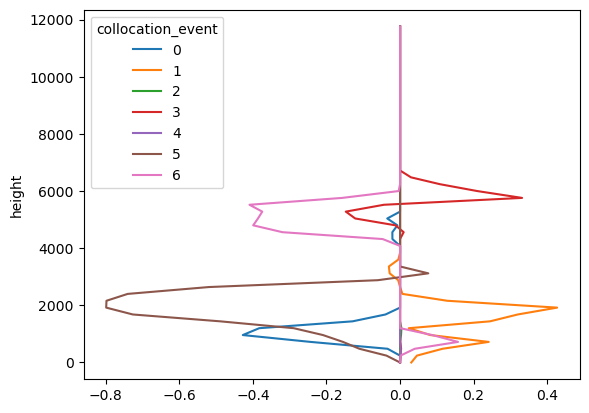

In [110]:
(multiple_vcf_pairs.vcf_atl09 - multiple_vcf_pairs.vcf_cloudnet).plot(y="height", hue="collocation_event")
plt.show()

# The power of xhistogram

In [30]:
from xhistogram.xarray import histogram as xhist

n_bins = 10
BINS_vcf = np.linspace(0,1,n_bins+1)
hist_da = xhist(
    multiple_vcf_pairs.vcf_atl09, 
    multiple_vcf_pairs.vcf_cloudnet,
    bins=[BINS_vcf, BINS_vcf], 
    dim=["collocation_event"],
    #density=True
)
hist_da

<xarray.DataArray 'histogram_vcf_atl09_vcf_cloudnet' (height: 50,
                                                      vcf_atl09_bin: 10,
                                                      vcf_cloudnet_bin: 10)> Size: 40kB
array([[[10,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        ...,
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0]],

       [[ 5,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        ...,
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0]],

       [[ 0,  3,  5, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  1,  0, ...,  0,  0,  0],
        ...,
...
        ...,
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0]],

       [[10,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        ...,
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0]],

       [[10,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        ...,
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0]]], shape=(50, 10, 10))
Coordinates:
  * height            (height) int64 400B 0 240 480 720 ... 11280 11520 11760
  * vcf_atl09_bin     (vcf_atl09_bin) float64 80B 0.05 0.15 0.25 ... 0.85 0.95
  * vcf_cloudnet_bin  (vcf_cloudnet_bin) float64 80B 0.05 0.15 ... 0.85 0.95

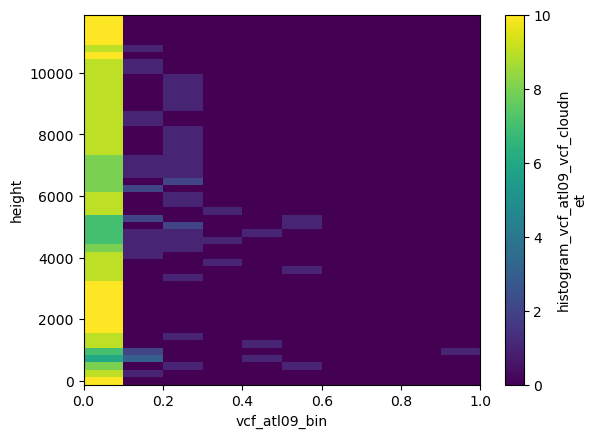

In [33]:
hist_da.sum(dim="vcf_cloudnet_bin").plot(y="height")
plt.show()

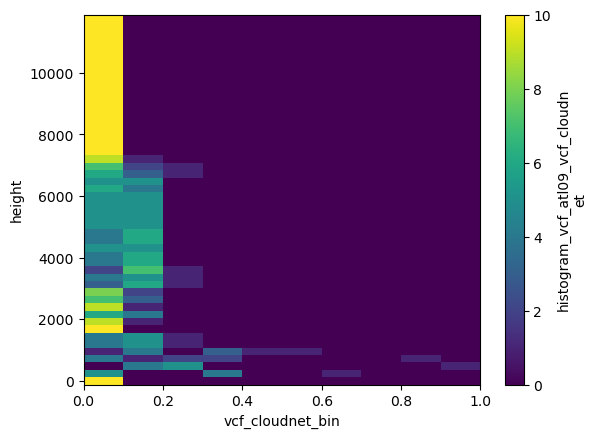

In [34]:
hist_da.sum(dim="vcf_atl09_bin").plot(y="height")
plt.show()

In [47]:
def fill_non_finite(da: xr.DataArray, fill_val = 0) -> xr.DataArray:
    return xr.where(
        np.isfinite(da),
        da,
        fill_val
    ).copy()

def entropy_with_height(counts: xr.DataArray, dim: str | list[str]) -> xr.DataArray:
    probability = counts / counts.sum(dim=dim)
    h = fill_non_finite(-np.log2(probability))
    return (
        (probability * h)
            .sum(dim=dim)
            .rename("entropy")
    )

In [48]:
def mutual_information_with_height(counts: xr.DataArray, dim: list[str]) -> xr.DataArray:
    probability = counts / counts.sum(dim=dim)
    log_term = fill_non_finite(
        np.log2(probability) 
        - np.log2(probability.sum(dim=dim[0])) 
        - np.log2(probability.sum(dim=dim[1]))
    )
    return (
        (probability * log_term)
            .sum(dim=dim)
            .rename("mutual_information")
    )

In [49]:
marginal_counts_atl09 = hist_da.sum(dim="vcf_cloudnet_bin")
marginal_counts_cloudnet = hist_da.sum(dim="vcf_atl09_bin")
entropy_atl09 = entropy_with_height(marginal_counts_atl09, "vcf_atl09_bin")
entropy_cloudnet = entropy_with_height(marginal_counts_cloudnet, "vcf_cloudnet_bin")
joint_entropy = entropy_with_height(hist_da, dim=["vcf_atl09_bin", "vcf_cloudnet_bin"])

/home/users/eeasm/mambaforge-pypy3/envs/overpass_analysis_again/lib/python3.13/site-packages/xarray/core/computation.py:824: RuntimeWarning: divide by zero encountered in log2
  result_data = func(*input_data)
/home/users/eeasm/mambaforge-pypy3/envs/overpass_analysis_again/lib/python3.13/site-packages/xarray/core/computation.py:824: RuntimeWarning: divide by zero encountered in log2
  result_data = func(*input_data)
/home/users/eeasm/mambaforge-pypy3/envs/overpass_analysis_again/lib/python3.13/site-packages/xarray/core/computation.py:824: RuntimeWarning: divide by zero encountered in log2
  result_data = func(*input_data)


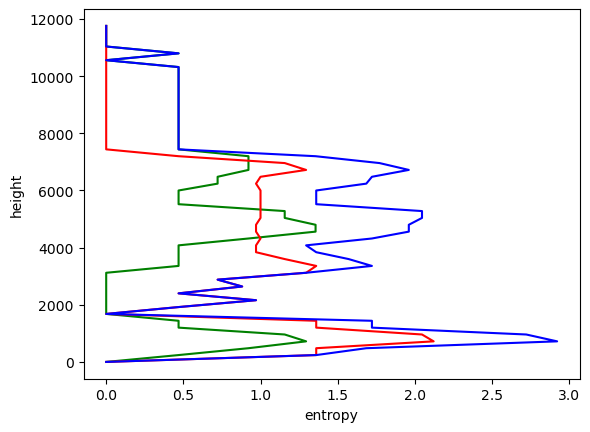

In [50]:
(
    entropy_atl09.plot(y="height", c="green"),
    entropy_cloudnet.plot(y="height", c="red"),
    joint_entropy.plot(y="height", c="blue")
)
plt.show()

In [51]:
MI_naive = entropy_atl09 + entropy_cloudnet - joint_entropy
MI_direct = mutual_information_with_height(hist_da, dim=["vcf_atl09_bin", "vcf_cloudnet_bin"])

/home/users/eeasm/mambaforge-pypy3/envs/overpass_analysis_again/lib/python3.13/site-packages/xarray/core/computation.py:824: RuntimeWarning: divide by zero encountered in log2
  result_data = func(*input_data)
/home/users/eeasm/mambaforge-pypy3/envs/overpass_analysis_again/lib/python3.13/site-packages/xarray/core/computation.py:824: RuntimeWarning: divide by zero encountered in log2
  result_data = func(*input_data)
/home/users/eeasm/mambaforge-pypy3/envs/overpass_analysis_again/lib/python3.13/site-packages/xarray/core/computation.py:824: RuntimeWarning: divide by zero encountered in log2
  result_data = func(*input_data)


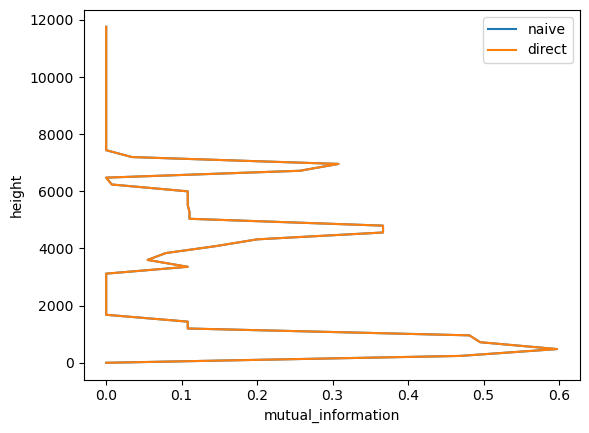

In [52]:
(
    MI_naive.plot(y="height", label="naive"),
    MI_direct.plot(y="height", label="direct")
)
plt.legend()
plt.show()

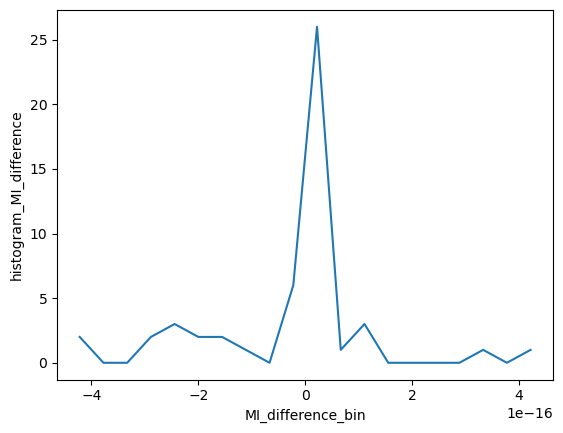

In [62]:
xhist((MI_naive - MI_direct).rename("MI_difference"), bins=20).plot(x="MI_difference_bin")
plt.show()